# **Neural Machine Translation**
### Deep Learning Project
### Phase-1

### **Metadata**:
There are 2 columns one column has english words/sentences and the other one has german words/sentences
And these dataset can be used for language translation task.

More datasets of different languages are available and can be downloaded from the below website: 

 http://www.manythings.org/anki/

## **Text Pre-processing and Analysis:**

#### Importing required libraries.

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [2]:
# Below is the function to read the raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [3]:
# defining a function to split the text into English-German pairs separated by ‘\n’. 
# then split the text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents


#### Importing our data and applying the above mentioned functions.

In [4]:
#We can now use these functions to read the text into an array in our desired format.

data = read_text("/content/drive/MyDrive/Colab Notebooks/DLProject//deu.txt")
deu_eng = to_lines(data)
print(data[0:175])

Go.	Geh.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)
Hi.	Hallo!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)


In [5]:
#converting the data into an array
deu_eng = array(deu_eng)

#### The actual data contains over 255,000 sentence-pairs. However, we will use only the first 50,000 sentence pairs to reduce the training time of the model. You can change this number as per your system’s computation power

In [11]:
print("Raw data has",deu_eng.shape[0],"examples.")

Raw data has 255817 examples.


In [12]:
deu_eng = deu_eng[:50000,:]
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ["They're coming again.", 'Sie kommen wieder.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2243605 (CK) & #6643044 (Felixjp)'],
       ["They're coming again.", 'Die kommen wieder.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2243605 (CK) & #6645385 (Felixjp)'],
       ["They're doing it now.", 'Sie tun es jetzt.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3740220 (CK) & #3815719 (nGerman)']],
      dtype='<U537')

In [13]:
print("The size of data has been reduced to",deu_eng.shape[0],"examples.")

The size of data has been reduced to 50000 examples.


#### Removing unnecessary information by retaining only the required text parts.

In [14]:
deu_eng1 = np.delete(deu_eng, 2 ,1)
deu_eng1

array([['Go.', 'Geh.'],
       ['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ...,
       ["They're coming again.", 'Sie kommen wieder.'],
       ["They're coming again.", 'Die kommen wieder.'],
       ["They're doing it now.", 'Sie tun es jetzt.']], dtype='<U537')

We will get rid of the punctuation marks and then convert all the text to lower case.

In [15]:
# Remove punctuation
deu_eng1[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng1[:,0]]
deu_eng1[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng1[:,1]]

deu_eng1

array([['Go', 'Geh'],
       ['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ...,
       ['Theyre coming again', 'Sie kommen wieder'],
       ['Theyre coming again', 'Die kommen wieder'],
       ['Theyre doing it now', 'Sie tun es jetzt']], dtype='<U537')

In [16]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng1[i,0] = deu_eng1[i,0].lower()
    deu_eng1[i,1] = deu_eng1[i,1].lower()

deu_eng1

array([['go', 'geh'],
       ['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ...,
       ['theyre coming again', 'sie kommen wieder'],
       ['theyre coming again', 'die kommen wieder'],
       ['theyre doing it now', 'sie tun es jetzt']], dtype='<U537')

#### A Seq2Seq model requires that we convert both the input and the output sentences into integer sequences of fixed length.

But before we do that, let’s visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [17]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng1[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng1[:,1]:
      deu_l.append(len(i.split()))

print()

Visualizing and comparing the length of sentences in both languages

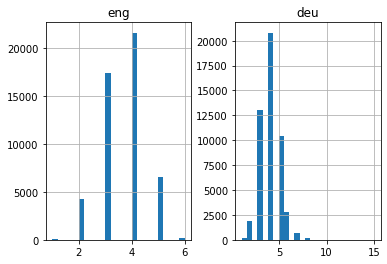

In [26]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 25)
plt.show()

The maximum length of the German sentences is 8 and that of the English phrases is 6.

#### Now, vectorize our text data by using Keras’s Tokenizer() class. It will turn our sentences into sequences of integers. We can then pad those sequences with zeros to make all the sequences of the same length.

In [19]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [20]:
# preparing english tokenizer
eng_tokenizer = tokenization(deu_eng1[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6125


In [21]:
# preparing Deutch tokenizer
deu_tokenizer = tokenization(deu_eng1[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10059


The below code block contains a function to prepare the sequences

In [22]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

### ***Conclusion:*** 

#### *We have removed all the unnecessary information from the raw data and performed data cleaning/pre-processing. Now, this data can be used to be fed into various Deep Learning models & compare their performances.*